# LSTM

數據集長度 154
原始訓練集的長度： 107
原始测試集的長度： 47
轉為監督式學習，訓練集數據長度： 99
轉為監督式學習，測試集數據長度： 39
Train on 79 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.0219 - acc: 0.2532 - val_loss: 0.0121 - val_acc: 0.2500
Epoch 2/100
 - 0s - loss: 0.0204 - acc: 0.2532 - val_loss: 0.0114 - val_acc: 0.2500
Epoch 3/100
 - 0s - loss: 0.0203 - acc: 0.2532 - val_loss: 0.0109 - val_acc: 0.2500
Epoch 4/100
 - 0s - loss: 0.0201 - acc: 0.2532 - val_loss: 0.0103 - val_acc: 0.2500
Epoch 5/100
 - 0s - loss: 0.0201 - acc: 0.2532 - val_loss: 0.0102 - val_acc: 0.2500
Epoch 6/100
 - 0s - loss: 0.0200 - acc: 0.2532 - val_loss: 0.0099 - val_acc: 0.2500
Epoch 7/100
 - 0s - loss: 0.0198 - acc: 0.2532 - val_loss: 0.0098 - val_acc: 0.2500
Epoch 8/100
 - 0s - loss: 0.0199 - acc: 0.2532 - val_loss: 0.0097 - val_acc: 0.2500
Epoch 9/100
 - 0s - loss: 0.0197 - acc: 0.2532 - val_loss: 0.0099 - val_acc: 0.2500
Epoch 10/100
 - 0s - loss: 0.0202 - acc: 0.2532 - val_loss: 0.0099 - val_acc: 0.2500
Epoch 11/100
 - 0s - loss: 0.0198 - ac

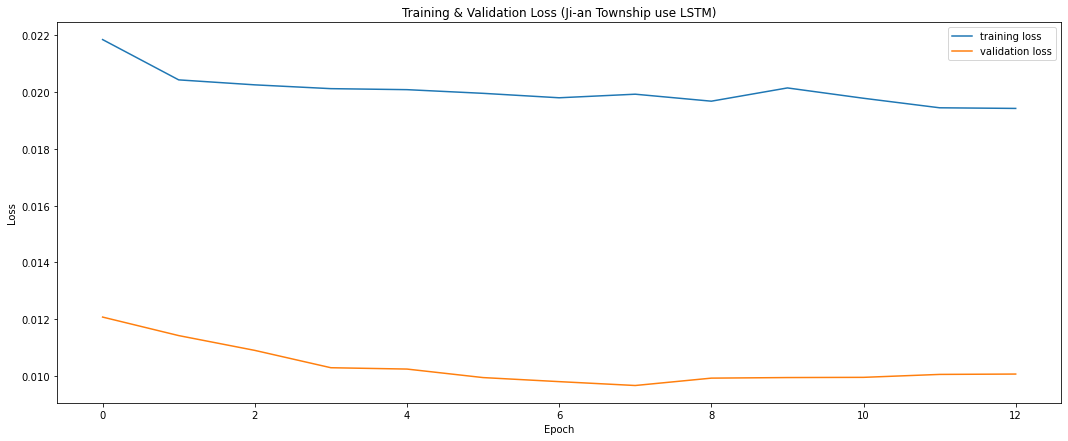

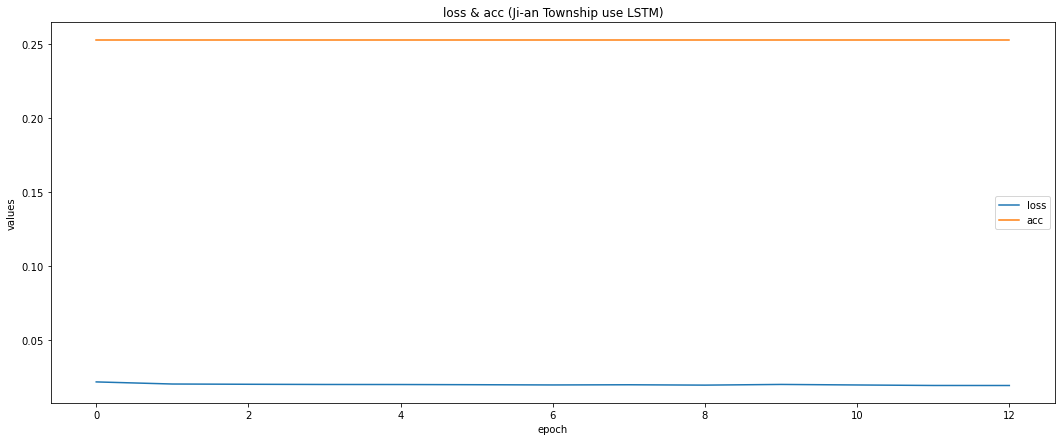

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                11600     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 255       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 11,861
Trainable params: 11,861
Non-trainable params: 0
_________________________________________________________________
Train Score: 7.22 RMSE
Test Score: 16.54 RMSE


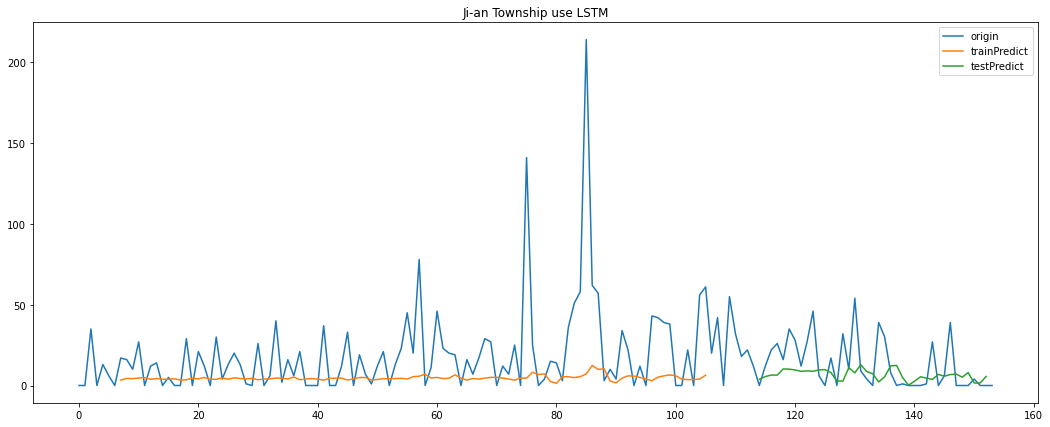

In [2]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

from keras.callbacks import EarlyStopping

# load the dataset
# import data
path = 'PATH'
data = pd.read_csv(path)

# NaN轉為0
data = data.fillna(0)

# 將float轉為integer
#data = data.astype('int')

print('數據集長度', len(data))
dataset = data.values
#print(dataset)

# 將數據拆分成訓練和测試，2/3作為訓練集
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print("原始訓練集的長度：",train_size)
print("原始测試集的長度：",test_size)

# X是給定時間(t)的乘客人数，Y是下一次(t + 1)的乘客人数。
# 将值数组转换为数据集矩阵,look_back是步長。
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        # X按照顺序取值
        dataX.append(a)
        # Y向後移動一位取值
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# 數據缩放
scaler = MinMaxScaler(feature_range=(0, 1))
#dataset = scaler.fit_transform(dataset)
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)

# 建構監督式學習數據
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back) 
print("轉為監督式學習，訓練集數據長度：", len(trainX))
# print(trainX,trainY)
print("轉為監督式學習，測試集數據長度：",len(testX))
# print(testX, testY )

# 數據為3D [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0,
                              patience = 5, verbose = 1, mode = 'min',
                              baseline = None, restore_best_weights = True)

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
history = model.fit(trainX, trainY, validation_split=0.2, epochs=100, batch_size=1, verbose=2,
                    callbacks = [early_stopping])

print('評估成效：', model.evaluate(testX, testY, verbose=2))

# summarize history for accuracy
plt.figure(figsize=(18,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training & Validation Loss (Ji-an Township use LSTM)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'validation loss'], loc='best')
plt.show()

# summarize history for accuracy
plt.figure(figsize=(18,7))
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])
plt.title('loss & acc (Ji-an Township use LSTM)')
plt.ylabel('values')
plt.xlabel('epoch')
plt.legend(['loss', 'acc'], loc='best')
plt.show()

# 打印模型
model.summary()

# 开始预测
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 逆缩放预测值
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# 计算误差
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

abc = numpy.array((154, 1))

# shift train predictions for plotting
trainPredictPlot = numpy.ones(abc)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.ones(abc)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(18,7))
plt.plot(dataset, label = 'origin')

#plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, label = 'trainPredict')
plt.plot(testPredictPlot, label = 'testPredict')
plt.title('Ji-an Township use LSTM')
plt.legend(loc = 'best')
plt.show()

# CNN-LSTM

數據集長度 154
原始训练集的长度： 77
原始测试集的长度： 77
转为监督学习，训练集数据长度： 69
转为监督学习，测试集数据长度： 69
构造得到模型的输入数据(训练数据已有标签trainY):  (69, 1, 1, 7) (69, 1, 1, 7)
Train on 55 samples, validate on 14 samples
Epoch 1/100
55/55 [==============================] - 1s 23ms/step - loss: 0.0197 - acc: 0.2909 - val_loss: 0.0776 - val_acc: 0.2143
Epoch 2/100
55/55 [==============================] - 0s 346us/step - loss: 0.0179 - acc: 0.2909 - val_loss: 0.0741 - val_acc: 0.2143
Epoch 3/100
55/55 [==============================] - 0s 376us/step - loss: 0.0161 - acc: 0.2909 - val_loss: 0.0711 - val_acc: 0.2143
Epoch 4/100
55/55 [==============================] - 0s 290us/step - loss: 0.0147 - acc: 0.2909 - val_loss: 0.0684 - val_acc: 0.2143
Epoch 5/100
55/55 [==============================] - 0s 282us/step - loss: 0.0137 - acc: 0.2909 - val_loss: 0.0660 - val_acc: 0.2143
Epoch 6/100
55/55 [==============================] - 0s 303us/step - loss: 0.0127 - acc: 0.2909 - val_loss: 0.0640 - val_acc: 0.2143
Epoch 7/100
55/55 [========

Epoch 61/100
55/55 [==============================] - 0s 278us/step - loss: 0.0079 - acc: 0.2909 - val_loss: 0.0654 - val_acc: 0.2143
Epoch 62/100
55/55 [==============================] - 0s 278us/step - loss: 0.0079 - acc: 0.2909 - val_loss: 0.0653 - val_acc: 0.2143
Epoch 63/100
55/55 [==============================] - 0s 270us/step - loss: 0.0078 - acc: 0.2909 - val_loss: 0.0654 - val_acc: 0.2143
Epoch 64/100
55/55 [==============================] - 0s 265us/step - loss: 0.0077 - acc: 0.2909 - val_loss: 0.0656 - val_acc: 0.2143
Epoch 65/100
55/55 [==============================] - 0s 255us/step - loss: 0.0076 - acc: 0.2909 - val_loss: 0.0658 - val_acc: 0.2143
Epoch 66/100
55/55 [==============================] - 0s 242us/step - loss: 0.0076 - acc: 0.2909 - val_loss: 0.0661 - val_acc: 0.2143
Epoch 67/100
55/55 [==============================] - 0s 269us/step - loss: 0.0075 - acc: 0.2909 - val_loss: 0.0666 - val_acc: 0.2143
Epoch 68/100
55/55 [==============================] - 0s 269us

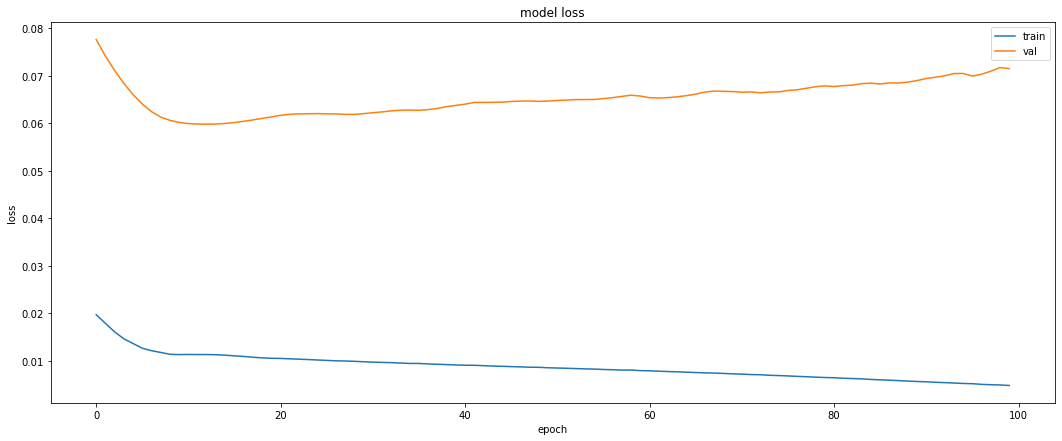

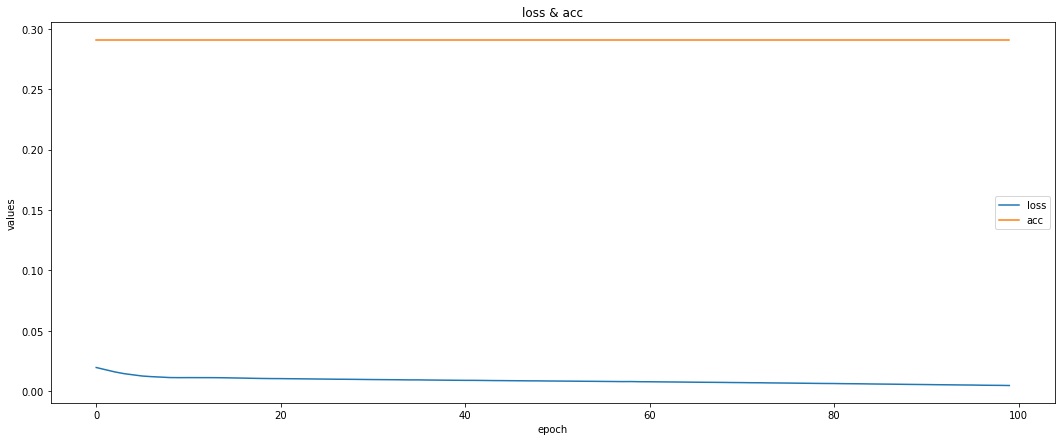

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 1, 1, 64)          512       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 1, 64)          0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 64)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 23,563
Trainable params: 23,563
Non-trainable params: 0
_________________________________________________________________
Train Score: 28.94 RMSE
Test Score: 39.02 RMSE


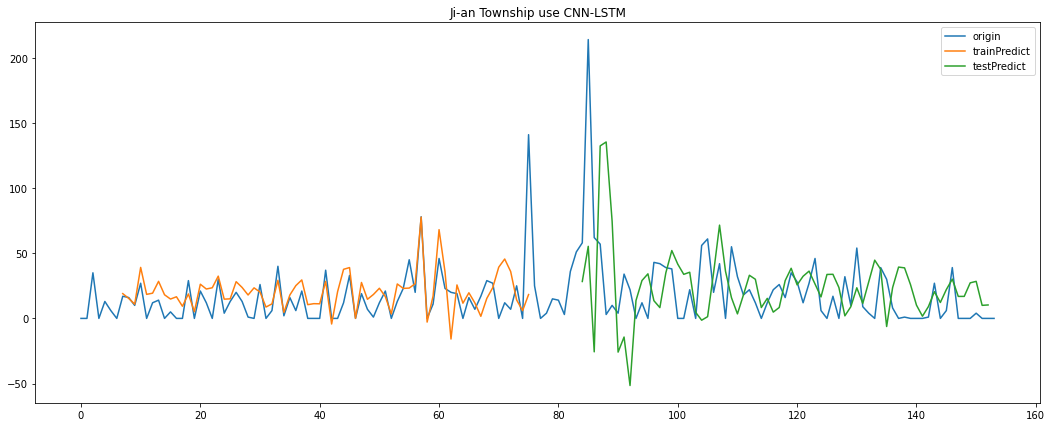

In [3]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

# load the dataset
# import data
path = 'PATH'
data = pd.read_csv(path)

# NaN轉為0
data = data.fillna(0)

# 將float轉為integer
#data = data.astype('int')

print('數據集長度', len(data))
dataset = data.values
#print(dataset)


# fix random seed for reproducibility
numpy.random.seed(7)

# 将数据拆分成训练和测试，2/3作为训练数据
train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)

# X是給定時間(t)的乘客人數，Y是下一次(t + 1)的乘客人數。
# look_back為步長。
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        # X按照顺序取值
        dataX.append(a)
        # Y向後移動一位取值
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)


# 數據正規化
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)

# 构建监督学习型数据
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back) 
print("转为监督学习，训练集数据长度：", len(trainX))
# print(trainX,trainY)
print("转为监督学习，测试集数据长度：",len(testX))
# print(testX, testY )

# 数据重构为4D [samples, subsequences, timesteps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1,1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0],1, 1, testX.shape[1]))
print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX.shape,testX.shape)

# create and fit the LSTM network
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(None,1, testX.shape[1]))))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm.add(TimeDistributed(Flatten()))

model_cnn_lstm.add(LSTM(50,activation='relu'))
model_cnn_lstm.add(Dense(1))

model_cnn_lstm.compile(loss='mse', optimizer='adam', metrics = ['acc'])

cnn_lstm_history = model_cnn_lstm.fit(trainX, trainY, validation_split = 0.2, epochs=100, verbose=1)
print('評估成效：', model_cnn_lstm.evaluate(testX, testY, verbose=1))


# summarize history for accuracy
plt.figure(figsize=(18,7))
plt.plot(cnn_lstm_history.history['loss'])
plt.plot(cnn_lstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

# summarize history for accuracy
plt.figure(figsize=(18,7))
plt.plot(cnn_lstm_history.history['loss'])
plt.plot(cnn_lstm_history.history['acc'])
plt.title('loss & acc')
plt.ylabel('values')
plt.xlabel('epoch')
plt.legend(['loss', 'acc'], loc='best')
plt.show()

###
# 打印模型
model_cnn_lstm.summary()

# 預測
trainPredict = model_cnn_lstm.predict(trainX)
testPredict = model_cnn_lstm.predict(testX)

# 還原預測值
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# 計算誤差
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

abc = numpy.array((154, 1))

# shift train predictions for plotting
trainPredictPlot = numpy.ones(abc)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.ones(abc)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(18,7))
plt.plot(dataset, label = 'origin')

#plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, label = 'trainPredict')
plt.plot(testPredictPlot, label = 'testPredict')
plt.title('Ji-an Township use CNN-LSTM')
plt.legend(loc = 'best')
plt.show()